In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [3]:
def plot_winds_currents(ax, filename_winds, filename_currents):
    axt = ax.twinx()

    winds = np.loadtxt(filename_winds, delimiter=",")
#     currents = np.loadtxt(filename_currents, delimiter=",")

    wind = winds[1]
#     current = general_functions.smooth(currents[1], 12)

    c_wind = '#EB8258'
#     c_current = '#38618C'
    
    lns1 = ax.plot(wind, c=c_wind, lw=2.5, ls='--', label='wind stress')
#     lns2 = axt.plot(current, c=c_current, lw=2.5, ls='-', label='alongshore velocity')
#     lns = lns1+lns2
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs, loc=4, ncol=2, fontsize=20)

    ax.set_xlabel('Time [hours]', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0, 10*24, 12))
    ax.set_xlim([0, 132])
    
    ax.set_ylabel('Wind stress\n[Nm$^{-2}$]', fontsize=20)
    min_y = -1.2
    ax.yaxis.set_ticks(np.linspace(0, min_y, 4))
    ax.set_ylim([min_y, 0])
    ax.spines['left'].set_color(c_wind)
    ax.yaxis.label.set_color(c_wind)
    
#     axt.set_ylabel('Alongshore\nvelocity [ms$^{-1}$]', rotation=270, fontsize=20, labelpad=55)
#     axt.yaxis.set_ticks(np.arange(0, -0.4, -0.1))
#     axt.set_ylim([-0.3, 0])
#     axt.spines['left'].set_color(c_current)
#     axt.yaxis.label.set_color(c_current)
    
    ax.grid(which='major', axis='both', linestyle='-')
    ax.tick_params(axis='both', which='both', length=0, labelsize=15)
    axt.tick_params(axis='both', which='both', length=0, labelsize=15)
    
    ax.add_patch(patches.Rectangle((0, min_y), (3.5), (0.3),
                                   fc='#C5C6CB', ec='#8F9491', lw=1.5, alpha=1))
    ax.annotate('i', xy=(1.5,-1.05),
                fontsize=30, weight='normal', va='center', ha='center')
    
    return ax

In [4]:
def get_varbs(kind, case, fname, meshmaskname, time_s):
    
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    with scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vovecrtz = dsW.variables['vovecrtz'][time_s, :, y, x]
        vosaline = dsT.variables['vosaline'][time_s, :, y, x]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
        
    print(fname)
        
    return vovecrtz, vosaline, e1t, e2t

In [5]:
def plot_streamlines(ax, kind, case, fname, meshmaskname, t_ind, time_all, vosaline_c, salt, x_shift, y_shift):
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')        
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    time_s = time_all[t_ind]
    
    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        vozocrtx = dsU.variables['vozocrtx'][time_s, :, y, x]
        vomecrty = dsV.variables['vomecrty'][time_s, :, y, x]
    
    u_daily = get_varb_surf(vosaline_c[t_ind, :, :, :], salt, vozocrtx)
    v_daily = get_varb_surf(vosaline_c[t_ind, :, :, :], salt, vomecrty)
    x_slice_c, y_slice_c, u_nstg, v_nstg, speeds = quicklook.get_speeds(u_daily, v_daily, 1)
    
    x_points_c, y_points_c = x_shift[x_slice_c], y_shift[y_slice_c]
    strm = ax.streamplot(x_points_c, y_points_c, u_nstg, v_nstg, color='k', density=2, linewidth=1)
        
    return ax

In [6]:
def get_varbs_series(kind, case, fname, meshmaskname, time_all):
    vovecrtz_c = np.full([len(time_all), 80, 242, 272], np.nan)
    vosaline_c = np.full([len(time_all), 80, 242, 272], np.nan)
    for time_s, n in zip(time_all, np.arange(len(time_all))):
        vovecrtz, vosaline, e1t_c, e2t_c = get_varbs(kind, case, fname, meshmaskname, time_s)
        vovecrtz_c[n, :, :, :] = vovecrtz
        vosaline_c[n, :, :, :] = vosaline
    return vovecrtz_c, vosaline_c, e1t_c, e2t_c

In [15]:
def plot_hovmoller(ax, vovecrtz_c, vosaline_c, e1t, e2t, salt, time_all, y_ind, x_shift, mid, vm):
    
    print(time_all)
    
    surface_time_c = np.full([len(time_all), vosaline_c.shape[-2], vosaline_c.shape[-1]], np.nan)

    for t in range(len(time_all)):
        varb_array = get_varb_surf(vosaline_c[t, :, :, :], salt, vovecrtz_c[t, :, :, :]) * 1000
        surface_time_c[t, :, :] = varb_array
        
    hovmoller_c = surface_time_c[:, y_ind, :]
    
    cmap = cmo.cm.balance
    cmap.set_bad('#A69F98')
    
    ax.pcolormesh(x_shift, np.arange(len(time_all)+1), hovmoller_c, vmin=-vm, vmax=vm, cmap=cmo.cm.balance)
    
    ax.tick_params(axis='both', which='both', length=0, labelsize=15)
    ax.set_xlabel('Alongshore (x)\ndistance [km]', fontsize=20)
    ax.yaxis.set_major_locator(plt.MaxNLocator(len(time_all)))
    ax.set_yticklabels(time_all)
    
    print(np.nanmin(hovmoller_c), np.nanmax(hovmoller_c))
    
    min_x, max_x = mid-100, mid+100
    ax.set_xlim([min_x, max_x])
    
    return ax, surface_time_c

In [16]:
def plot_map(ax, surface_time_c, y_ind, t_ind, time_all, x_shift, y_shift, mid, labs, vm):
        
    cmap = cmo.cm.balance
    cmap.set_bad('#A69F98')
       
    p = ax.pcolormesh(x_shift, y_shift, surface_time_c[t_ind, :, :], vmin=-vm, vmax=vm, cmap=cmo.cm.balance)
    ax.axhline(y_shift[y_ind], c='k', ls='--', lw=3)
    
    ax.tick_params(axis='both', which='both', length=0, labelsize=15)
    ax.set_aspect(aspect='equal')
    ax.set_xlabel('Alongshore (x)\ndistance [km]', fontsize=20)

    min_x, max_x, min_y, max_y = mid-100, mid+100, 25, 200
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    
#     ind_y = 45
#     ind_y_mid = ind_y+(ind_y-min_x)*0.5
#     ind_x_mid = min_x+(ind_y-min_x)*0.2
    ax.add_patch(patches.Rectangle((min_x, min_y),(25),(25),
                                   fc='#C5C6CB', ec='#8F9491', lw=1.5, alpha=1))
    ax.annotate(labs, xy=(min_x+10, 37),
                fontsize=30, weight='normal', va='center', ha='center')
    
    ax.annotate('hour '+str(time_all[t_ind]), xy=(max_x-60, 40), fontsize=20)
    
    return ax, p

In [19]:
time_all = np.arange(12, 61, 6) #np.array([30, 48, 60])
salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694

case='base'
fname = '1_MCKNZ*'
meshmaskname = '1_mesh_mask.nc'

vovecrtz_ci, vosaline_ci, e1t_ci, e2t_ci = get_varbs_series('ideal', case, fname, meshmaskname, time_all)
vovecrtz_cr, vosaline_cr, e1t_cr, e2t_cr = get_varbs_series('real', case, fname, meshmaskname, time_all)

1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*
1_MCKNZ*


[12 18 24 30 36 42 48 54 60]
-1.9093424553609217 1.6513592282055187
[12 18 24 30 36 42 48 54 60]
-0.848406475350874 1.8428671463921118
[12 18 24 30 36 42 48 54 60]
-0.8344114207476067 1.4524979451390503
[12 18 24 30 36 42 48 54 60]
-4.090085610925225 1.54208256871537


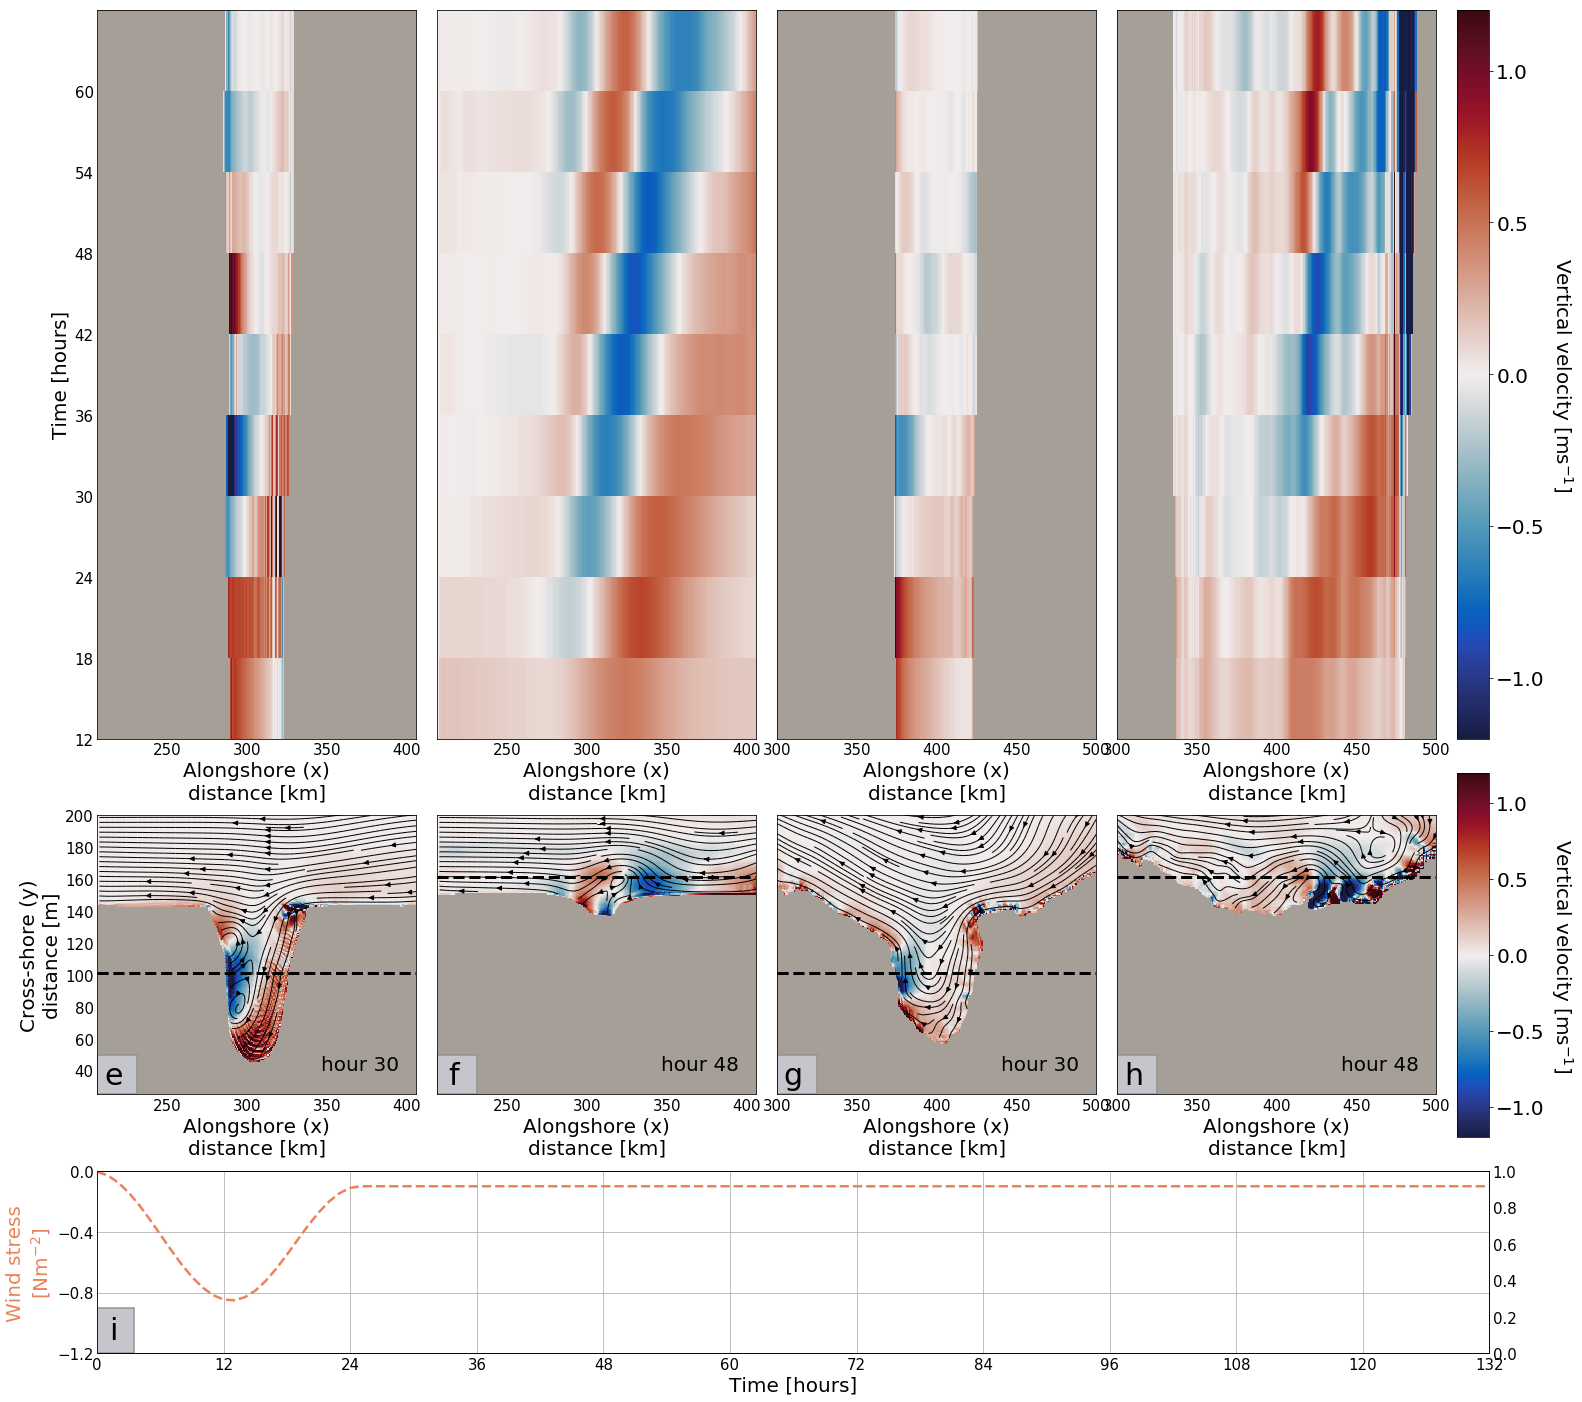

In [20]:
kinds = ['ideal', 'ideal', 'real', 'real']
salts = [salt_UHW_SA, salt_ATW_SA, salt_UHW_SA, salt_ATW_SA]
y_inds = [100, 180, 100, 180]
t_bots = [30, 48, 30, 48]
labs_bot = ['e', 'f', 'g', 'h']

fig = plt.figure(figsize=(20, 19))
gs = gridspec.GridSpec(3, 5, width_ratios=[1,1,1,1,0.1], height_ratios=[2,1,0.5])
ax1 = plt.subplot(gs[0, 0], sharex=ax5)
ax2 = plt.subplot(gs[0, 1], sharex=ax6, sharey=ax1)
ax3 = plt.subplot(gs[0, 2], sharex=ax7, sharey=ax1)
ax4 = plt.subplot(gs[0, 3], sharex=ax8, sharey=ax1)
axt = plt.subplot(gs[0, 4])

ax5 = plt.subplot(gs[1, 0])
ax6 = plt.subplot(gs[1, 1], sharey=ax5)
ax7 = plt.subplot(gs[1, 2], sharey=ax5)
ax8 = plt.subplot(gs[1, 3], sharey=ax5)
axb = plt.subplot(gs[1, 4])

fig.tight_layout()

axlong = plt.subplot(gs[2,:])

axes_top = [ax1, ax2, ax3, ax4]
axes_bot = [ax5, ax6, ax7, ax8]

for ax in ([ax2, ax3, ax4, ax6, ax7, ax8]):
    ax.yaxis.set_tick_params(labelbottom=False)

vm = 1.2

for ax_top, ax_bot, t_bot, kind, salt, y_ind, lab_bot, n in zip(axes_top, axes_bot, t_bots, kinds, salts, y_inds, labs_bot, np.arange(4)): 
    if kind == 'ideal':
        vovecrtz_c, vosaline_c, e1t_c, e2t_c = vovecrtz_ci, vosaline_ci, e1t_ci, e2t_ci
        x_left, y_bottom = 205.822543591543,24.85159075988878
        mid = 306
    elif kind == 'real':
        vovecrtz_c, vosaline_c, e1t_c, e2t_c = vovecrtz_cr, vosaline_cr, e1t_cr, e2t_cr
        x_left, y_bottom = 296.29431501679437, 24.85159075988878
        mid = 400
        
    x_shift, y_shift = x_left+e1t_c, y_bottom+e2t_c
    
    ax_top, surface_time_c = plot_hovmoller(ax_top, vovecrtz_c, vosaline_c, e1t_c, e2t_c, 
                                            salt, time_all, y_ind, x_shift, mid, vm)
    
    t_ind = np.where(time_all==t_bot)[0][0]
    
    ax_bot, p = plot_map(ax_bot, surface_time_c, y_ind, t_ind, time_all, x_shift, y_shift, mid, lab_bot, vm)
    
    ax_bot = plot_streamlines(ax_bot, kind, case, fname, meshmaskname, 
                              t_ind, time_all, vosaline_c, salt, x_shift, y_shift)
    
    if n==3:
        for ax in [axt, axb]:
            cbar = fig.colorbar(p, cax=ax, orientation='vertical', fraction=5.0, aspect=15, pad=5.8)
            cbar_lab = 'Vertical velocity [ms$^{-1}$]'
            cbar.ax.tick_params(labelsize=20)
            cbar.ax.set_ylabel(cbar_lab, rotation=270, fontsize=20)
            cbar.ax.get_yaxis().labelpad = 30  
        
#     if ax_top == ax1:
#         ax_top.set_xlim([mid-25, mid+25])
#     elif ax_top == ax3:
#         ax_top.set_xlim([mid-30, mid+30])
        
axes_top[0].set_ylabel('Time [hours]', fontsize=20)
axes_bot[0].set_ylabel('Cross-shore (y)\ndistance [m]', fontsize=20)
    
if kind == 'ideal':
    filename_currents = './files/currents_ideal.out'
    filename_winds = './files/winds_ideal.out'
elif kind == 'real':
    filename_currents = './files/currents_real.out'
    filename_winds = './files/winds_real.out'
axlong = plot_winds_currents(axlong, filename_winds, None)

fig.patch.set_facecolor('white')    
plt.subplots_adjust(top=0.99, wspace=0.08, hspace=0.08)
fig.savefig('./fig_hovmoller.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())